In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import scipy as sp
import h5py
from functools import reduce
import matplotlib.lines as mlines

sys.path.append('../methods/')

def legend_title_left(leg):
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()

method_list = ['causarray', 'RUV-III-NB', 'RUV', 'Mixscape', 'CINEMA-OT-W', 'CINEMA-OT', 'CoCoA', 'DESeq2', 'Wilcoxon']
palette = sns.color_palette()[:len(method_list)]
hue_order = {i:c for i,c in zip(method_list, palette) }

# Confounding levels

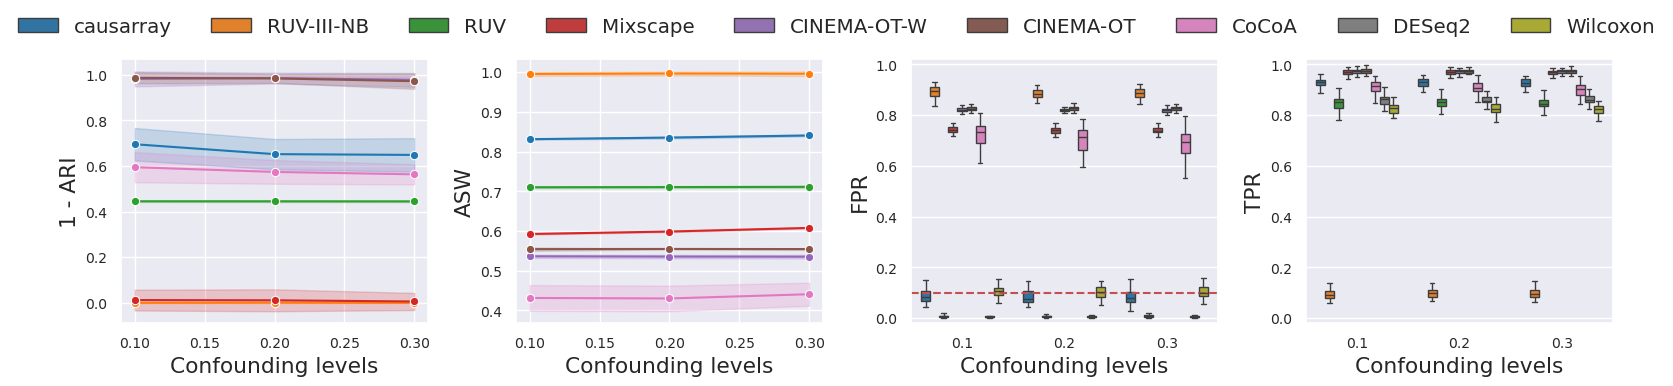

In [2]:
path_base = '/home/jinandmaya/simu_nb/'

df_test = pd.DataFrame()
df_cf = pd.DataFrame()
d = 1; r = 4
for noise in [0.1,0.2,0.3]:
    ind = '_d_{}_r_{}_noise_{}'.format(d,r,noise)
    try:
        _df_test = pd.read_csv(path_base+'results/result{}_test.csv'.format(ind)).rename({'FDR':'FPR', 'power':'TPR'}, axis=1)
        _df_cf = pd.read_csv(path_base+'results/result{}_deconfound.csv'.format(ind))
        _df_test['noise'] = noise
        _df_cf['noise'] = noise
        df_test = pd.concat([df_test, _df_test], axis=0)
        df_cf = pd.concat([df_cf, _df_cf], axis=0)
    except:
        continue

r_list = [4]
n_list = [500]
method_name = {
    'wilc':'Wilcoxon', 'DESeq':'DESeq2', 'cocoa':'CoCoA', 'cinemaot':'CINEMA-OT', 'cinemaotw':'CINEMA-OT-W', 'mixscape':'Mixscape',
    }
    
method_name.update(
    reduce(lambda a, b: dict(a, **b), 
    [{'ruv_r_{}'.format(r):'RUV' for r in r_list}, 
      {'ruv3nb_r_{}'.format(r):'RUV-III-NB' for r in r_list}, 
      {'causarray_r_{}'.format(r):'causarray' for r in r_list} 
    ])
    )
df_test = df_test[df_test['method'].isin(method_name.keys())]
df_cf = df_cf[df_cf['method'].isin(method_name.keys())]
df_test['method'] = df_test['method'].map(method_name)
df_cf['method'] = df_cf['method'].map(method_name)
df_test = df_test[df_test['n'].isin(n_list)].reset_index(drop=True)
df_cf = df_cf[df_cf['n'].isin(n_list)].reset_index(drop=True)

df_cf['ARI'] = 1 - df_cf['ARI'] # ct is a confounder, so we want to minimize ARI

zmax = df_cf.groupby(['n','method'])[['ARI', 'ASW']].median().max().values
zmin = 0. * zmax
df_cf[['ARI', 'ASW']] = (df_cf[['ARI', 'ASW']].values - zmin) / (zmax - zmin)
df_cf[['ARI', 'ASW']] = np.clip(df_cf[['ARI', 'ASW']], 0, 1)

sns.set(font_scale=1.3)
fig, axes = plt.subplots(1,4, figsize=(16,4), sharex=False, sharey=False)
for j, metric in enumerate(['FPR', 'TPR']):
    sns.boxplot(data=df_test, x='noise', y=metric, hue='method', hue_order=hue_order,
        ax=axes[j+2], palette=palette, showfliers=False)

for j, metric in enumerate(['ARI', 'ASW']):
    sns.lineplot(data=df_cf, x='noise', y=metric, hue='method', hue_order=hue_order,
        ax=axes[j], palette=palette, marker='o', errorbar='sd')

axes[0].set_ylabel('1 - ARI')
axes[2].axhline(0.1, color='r', linestyle='--')
lines_labels = [ax.get_legend_handles_labels() for ax in [axes[-1]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]


for j in range(4):
    if j>1:
        axes[j].set_ylim(-0.02,1.02)
    axes[j].get_legend().remove()
    axes[j].tick_params(axis='both', which='major', labelsize=10)
    axes[j].set_xlabel('Confounding levels')
legend = fig.legend(handles=handles, labels=labels,
                    loc=9, ncol=10, title=None, frameon=False)           
legend_title_left(legend)

fig.tight_layout()
fig.subplots_adjust(top=0.85)

plt.savefig(path_base + 'results/simu_nb_d_{}_r_{}.pdf'.format(d,r), bbox_inches='tight', pad_inches=0, dpi=300)

# Sample sizes

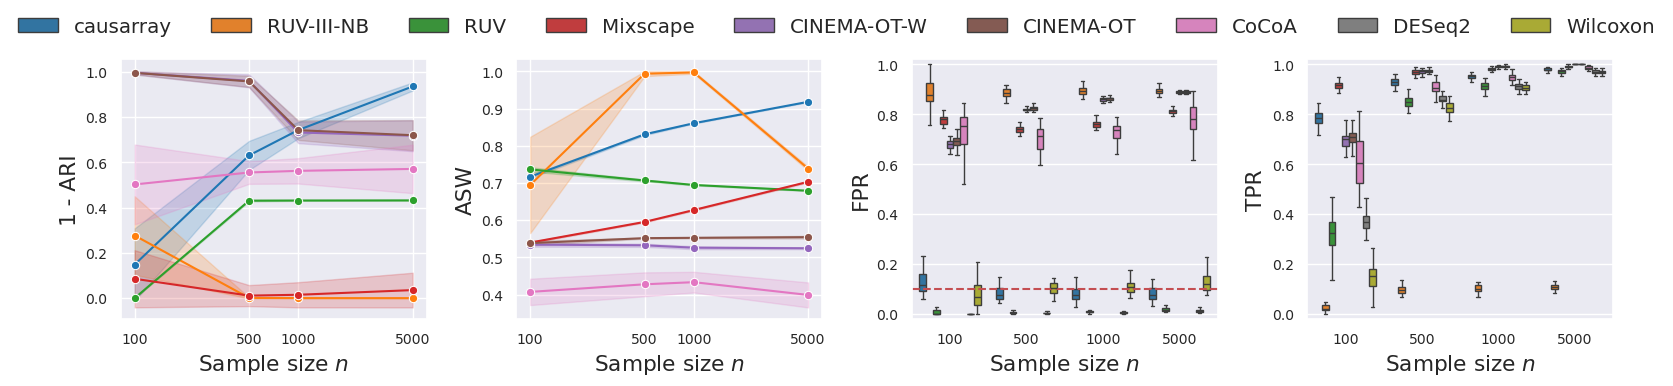

In [3]:
path_base = '/home/jinandmaya/simu_nb/'
ind = '_d_1_r_4_noise_0.2'

df_test = pd.read_csv(path_base+'results/result{}_test.csv'.format(ind)).rename({'FDR':'FPR', 'power':'TPR'}, axis=1)
df_cf = pd.read_csv(path_base+'results/result{}_deconfound.csv'.format(ind))

r_list = [4]
n_list = [100, 500, 1000, 5000]
method_name = {
    'wilc':'Wilcoxon', 'DESeq':'DESeq2', 'cocoa':'CoCoA', 'cinemaot':'CINEMA-OT', 'cinemaotw':'CINEMA-OT-W', 'mixscape':'Mixscape',
    }
    
method_name.update(
    reduce(lambda a, b: dict(a, **b), 
    [{'ruv_r_{}'.format(r):'RUV' for r in r_list}, 
      {'ruv3nb_r_{}'.format(r):'RUV-III-NB' for r in r_list}, 
      {'causarray_r_{}'.format(r):'causarray' for r in r_list} 
    ])
    )

df_test = df_test[df_test['method'].isin(method_name.keys())]
df_cf = df_cf[df_cf['method'].isin(method_name.keys())]
df_test['method'] = df_test['method'].map(method_name)
df_cf['method'] = df_cf['method'].map(method_name)

df_test = df_test[df_test['n'].isin(n_list)]
df_cf = df_cf[df_cf['n'].isin(n_list)]

df_cf['ARI'] = 1 - df_cf['ARI'] # ct is a confounder, so we want to minimize ARI
zmax = df_cf.groupby(['n','method'])[['ARI', 'ASW']].median().max().values
zmin = 0. * zmax
df_cf[['ARI', 'ASW']] = (df_cf[['ARI', 'ASW']].values - zmin) / (zmax - zmin)
df_cf[['ARI', 'ASW']] = np.clip(df_cf[['ARI', 'ASW']], 0, 1)
    
sns.set(font_scale=1.3)
fig, axes = plt.subplots(1,4, figsize=(16,4), sharex=False, sharey=False)
for j, metric in enumerate(['FPR', 'TPR']):
    sns.boxplot(data=df_test, x='n', y=metric, hue='method', hue_order=hue_order,
        ax=axes[j+2], palette=palette, showfliers=False)

for j, metric in enumerate(['ARI', 'ASW']):
    sns.lineplot(data=df_cf, x='n', y=metric, hue='method', hue_order=hue_order,
        ax=axes[j], palette=palette, marker='o', errorbar='sd')
    axes[j].set_xscale('log')
    axes[j].set_xticks(n_list)
    axes[j].set_xticklabels(n_list)
axes[0].set_ylabel('1 - ARI')
axes[2].axhline(0.1, color='r', linestyle='--')
lines_labels = [ax.get_legend_handles_labels() for ax in [axes[-1]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]


for j in range(4):
    if j>1:
        axes[j].set_ylim(-0.02,1.02)
    axes[j].get_legend().remove()
    axes[j].tick_params(axis='both', which='major', labelsize=10)
    axes[j].set_xlabel('Sample size $n$')
legend = fig.legend(handles=handles, labels=labels,
                    loc=9, ncol=10, title=None, frameon=False)           
legend_title_left(legend)

fig.tight_layout()
fig.subplots_adjust(top=0.85)

plt.savefig(path_base + 'results/simu_nb{}.pdf'.format(ind), bbox_inches='tight', pad_inches=0, dpi=300)

# Number of latent variables

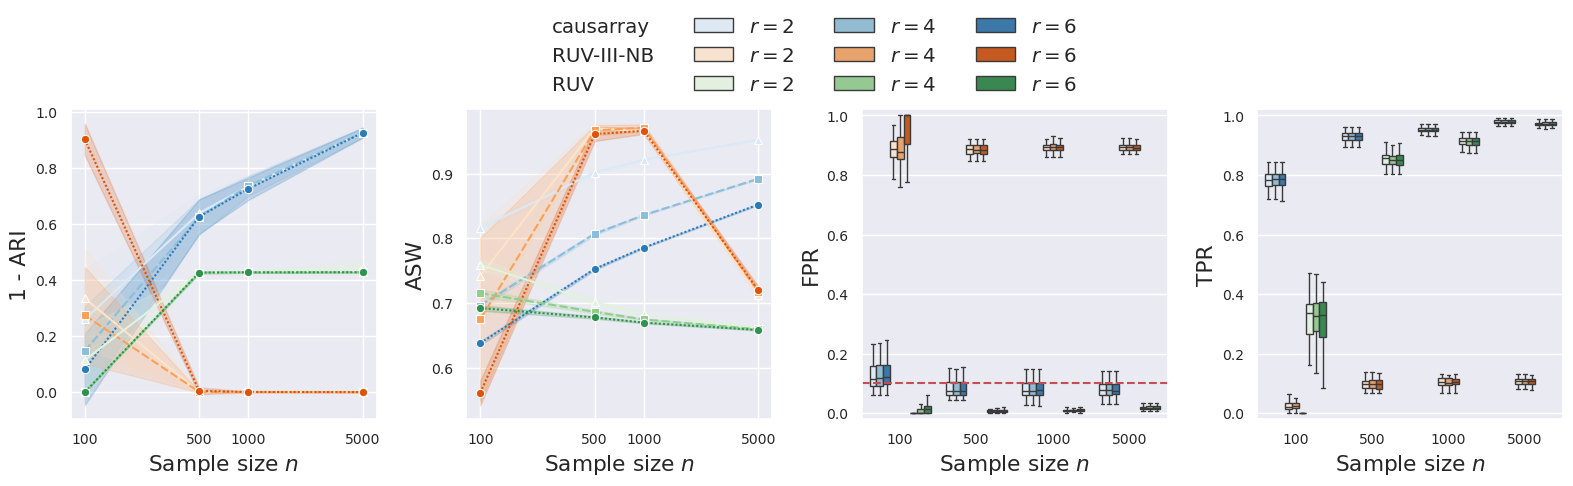

In [ ]:
path_base = '/home/jinandmaya/simu_nb/'
ind = '_d_1_r_4_noise_0.2'

df_test = pd.read_csv(path_base+'results/result{}_test.csv'.format(ind)).rename({'FDR':'FPR', 'power':'TPR'}, axis=1)
df_cf = pd.read_csv(path_base+'results/result{}_deconfound.csv'.format(ind))

r_list = [2,4,6]
n_list = [100, 500, 1000, 5000]
    
method_name = reduce(lambda a, b: dict(a, **b), 
    [{'causarray_r_{}'.format(r):'causarray $r={}$'.format(r) for r in r_list},
      {'ruv3nb_r_{}'.format(r):'RUV-III-NB $r={}$'.format(r) for r in r_list},
      {'ruv_r_{}'.format(r):'RUV $r={}$'.format(r) for r in r_list}
    ])

df_test = df_test[df_test['method'].isin(method_name.keys())]
df_cf = df_cf[df_cf['method'].isin(method_name.keys())]
df_test['method'] = df_test['method'].map(method_name)
df_cf['method'] = df_cf['method'].map(method_name)

df_test = df_test[df_test['n'].isin(n_list)]
df_cf = df_cf[df_cf['n'].isin(n_list)]
df_cf['r'] = df_cf['method'].str.extract(r'r=(\d+)').astype(int)
df_cf['ARI'] = 1 - df_cf['ARI'] # ct is a confounder, so we want to minimize ARI

method_list = list(method_name.values())
palette = reduce(lambda l1, l2: l1+l2, [sns.color_palette(name)[:len(r_list)*2:2] for name in ['Blues', 'Oranges', 'Greens']])
hue_order = {i:c for i,c in zip(method_list, palette) }

sns.set(font_scale=1.3)
fig, axes = plt.subplots(1,4, figsize=(16,5), sharex=False, sharey=False)
for j, metric in enumerate(['FPR', 'TPR']):
    sns.boxplot(data=df_test, x='n', y=metric, hue='method', hue_order=hue_order,
        ax=axes[j+2], palette=palette, showfliers=False)

for j, metric in enumerate(['ARI', 'ASW']):
    sns.lineplot(data=df_cf, x='n', y=metric, hue='method', hue_order=hue_order,
                 style_order=[2,4,6], markers=['^', 's', 'o'],
        ax=axes[j], palette=palette, style='r', errorbar='sd')    
    axes[j].set_xscale('log')
    axes[j].set_xticks(n_list)
    axes[j].set_xticklabels(n_list)
        
axes[0].set_ylabel('1 - ARI')
axes[2].axhline(0.1, color='r', linestyle='--')
lines_labels = [ax.get_legend_handles_labels() for ax in [axes[-1]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
handles = [mlines.Line2D([], [], linestyle='None')] * 3 + handles[::3] + handles[1::3] + handles[2::3]
labels = ['causarray', 'RUV-III-NB', 'RUV',
            '$r=2$', '$r=2$', '$r=2$',
            '$r=4$', '$r=4$', '$r=4$',
            '$r=6$', '$r=6$', '$r=6$']

for j in range(4):
    if j>1:
        axes[j].set_ylim(-0.02,1.02)
    axes[j].get_legend().remove()
    axes[j].tick_params(axis='both', which='major', labelsize=10)
    axes[j].set_xlabel('Sample size $n$')
legend = fig.legend(handles=handles, labels=labels,
                    loc=9, ncol=4, title=None, frameon=False)           
legend_title_left(legend)

fig.tight_layout()
fig.subplots_adjust(top=0.78)

plt.savefig(path_base + 'results/simu_nb_r{}.pdf'.format(ind), bbox_inches='tight', pad_inches=0, dpi=300)